<a href="https://colab.research.google.com/github/Elvira-Zainulina/ml_MRI_age_prediction/blob/master/Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install torchio

     |████████████████████████████████| 71kB 3.6MB/s 
     |████████████████████████████████| 42.5MB 70kB/s 
  Created wheel for Python-Deprecated: filename=Python_Deprecated-1.1.0-py2.py3-none-any.whl size=3069 sha256=9c55807e8d6d87934a952e62ae0db08001a0529a6b66159983b846c84f6dfc96
  Stored in directory: /root/.cache/pip/wheels/b8/f1/81/2a12cf4208f219e3f023a6211a47165e74e50d534c6a3c3e64
Successfully built Python-Deprecated


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Visualization of the features of Baseline method (KernelPCA) and VAE-C

In [3]:
import numpy as np
import torch
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
from models import VAE_age, VAE_encoder
from ml_utils.data import S500MRI_Dataset_simple
from ml_utils.uploading import load_data
from torch.utils.data import DataLoader
from ml_utils.preprocessing import num2lab
from ml_utils.preprocessing import num2gender

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


If you use TorchIO for your research, please cite the following paper:

Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning
(https://arxiv.org/abs/2003.04696)


In [0]:
#path to the folder with datasets that were created in the Data_preparation.ipynb
path = r"drive/My Drive/Colab Notebooks/ml-project/data" 

### Data uploading

In [0]:
X_train, y_train, g_train = load_data(os.path.join(path, 'train_dataset.npy'))
X_val, y_val, g_val = load_data(os.path.join(path, 'val_dataset.npy'))
X_test, y_test, g_test = load_data(os.path.join(path, 'test_dataset.npy'))

### Getting features

#####Baseline method

Fitting KernelPCA for the Baseline method in order to get its features.

In [7]:
X_train_full = np.vstack([X_train, X_val])
X_train_full = X_train_full.reshape((X_train_full.shape[0], -1))
X_train_full.shape

(800, 2097152)

In [0]:
pca = KernelPCA(n_components=100, kernel='rbf', n_jobs=-1, 
                copy_X=False, random_state=42)

In [9]:
%%time
X_train_full = pca.fit_transform(X_train_full)

CPU times: user 7min 7s, sys: 49.4 s, total: 7min 56s
Wall time: 3min 5s


In [0]:
X_test_b = pca.transform(X_test.reshape((X_test.shape[0], -1)))

#####VAE-C for $4$-class classification

Getting features of VAE-C via VAE-encoder

In [0]:
train_data = S500MRI_Dataset_simple(X_train, g_train, y_train)
val_data = S500MRI_Dataset_simple(X_val, g_val, y_val)
test_data = S500MRI_Dataset_simple(X_test, g_test, y_test)

In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = torch.load(os.path.join(path, 'VAE_clf_s100.pt'))

In [0]:
def get_latent_repr(model, data):
    model.eval()

    latent_repr = []
    dataloader = DataLoader(data, batch_size=20, shuffle=False, num_workers=4)
    for sample in tqdm(dataloader):
        img, gender, age = sample
        img = img.to(device)
        age = age.to(device)
        gender = gender.to(device)
        output = net.encoder(img, gender)
        a_mean, a_log_var, z_mean, z_log_var, a, z, z_a  = model.encoder(img, gender)
        latent_repr.append(z.cpu().detach().numpy())
    latent_repr = np.concatenate(latent_repr)
    return latent_repr    

In [14]:
latent_train = get_latent_repr(net, train_data)
latent_train.shape

(700, 16)

In [15]:
latent_val = get_latent_repr(net, val_data)
latent_val.shape

(100, 16)

In [16]:
latent_test = get_latent_repr(net, test_data)
latent_test.shape

(99, 16)

#####VAE-C for $2$-class classification

Getting features of VAE-C via VAE-encoder

In [0]:
train_data = S500MRI_Dataset_simple(X_train, g_train, y_train, group_ages=True)
val_data = S500MRI_Dataset_simple(X_val, g_val, y_val, group_ages=True)
test_data = S500MRI_Dataset_simple(X_test, g_test, y_test, group_ages=True)

In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = torch.load(os.path.join(path, 'VAE_clf_2.pt'))

In [19]:
latent_train2 = get_latent_repr(net, train_data)
latent_train2.shape

(700, 16)

In [20]:
latent_val2 = get_latent_repr(net, val_data)
latent_val2.shape

(100, 16)

In [21]:
latent_test2 = get_latent_repr(net, test_data)
latent_test2.shape

(99, 16)

#### Deleting unnecessary elements

In [22]:
del X_train
del X_val
del X_test
gc.collect()

53

### Getting labels for visualization

In [0]:
ages = np.hstack([y_train, y_val, y_test])
ages = np.array(list(map(lambda x: num2lab[x], ages)))

In [0]:
genders = np.hstack([g_train, g_val, g_test])
genders = np.array(list(map(lambda x: num2gender[x], genders)))

## Visualization

In [0]:
def visuzalization(tsne_results, y, output_path=None):
    df = pd.DataFrame(tsne_results, columns=['tsne-2d-one', 'tsne-2d-two'])
    df['y'] = y

    n = len(np.unique(y))
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue="y",
        palette=sns.color_palette("hls", n),
        data=df,
        legend="full"
    )
    plt.legend(fontsize=14)
    if output_path:
        plt.savefig(output_path)
    plt.show()

### Baseline method

In [26]:
X_full_b = np.vstack([X_train_full, X_test_b])
X_full_b.shape

(899, 100)

In [0]:
tsne_b = TSNE(random_state=42, verbose=10, n_jobs=-1, 
              n_iter=10000, learning_rate=50, )

In [28]:
X_full_b = tsne_b.fit_transform(X_full_b)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 899 samples in 0.014s...
[t-SNE] Computed neighbors for 899 samples in 0.111s...
[t-SNE] Computed conditional probabilities for sample 899 / 899
[t-SNE] Mean sigma: 0.172089
[t-SNE] Computed conditional probabilities in 0.079s
[t-SNE] Iteration 50: error = 67.0206604, gradient norm = 0.2074293 (50 iterations in 0.301s)
[t-SNE] Iteration 100: error = 67.6996078, gradient norm = 0.2455143 (50 iterations in 0.264s)
[t-SNE] Iteration 150: error = 67.3196182, gradient norm = 0.1394125 (50 iterations in 0.283s)
[t-SNE] Iteration 200: error = 66.9031143, gradient norm = 0.1548827 (50 iterations in 0.280s)
[t-SNE] Iteration 250: error = 67.0414276, gradient norm = 0.1303241 (50 iterations in 0.271s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.041428
[t-SNE] Iteration 300: error = 1.8995967, gradient norm = 0.0026299 (50 iterations in 0.229s)
[t-SNE] Iteration 350: error = 1.7542083, gradient norm = 0.0008480 (

Visualization of all data depending on ages.

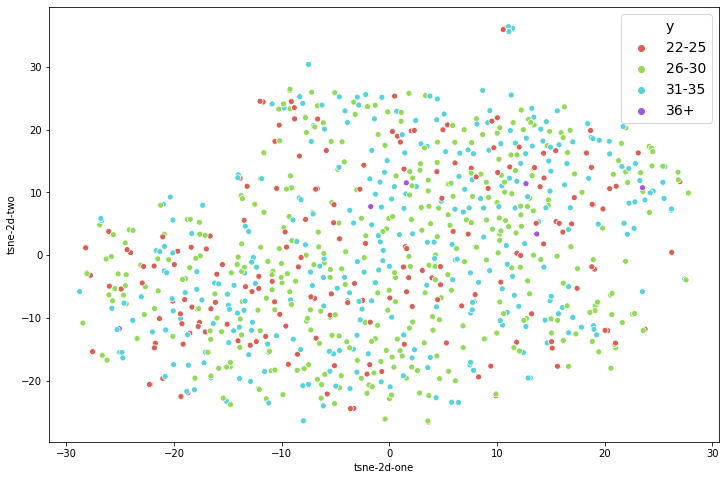

In [69]:
visuzalization(X_full_b, ages, output_path=os.path.join(path, 'pca_all_ages.pdf'))

Visualization of features of objects with gender feature 'Female'.

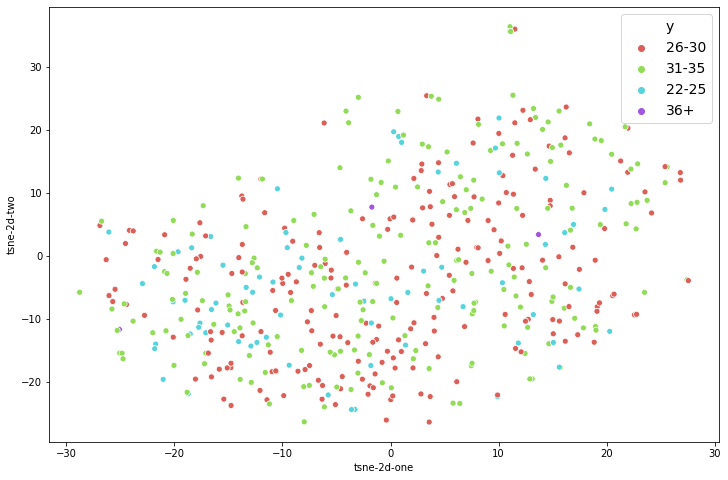

In [70]:
visuzalization(X_full_b[genders=='F'], ages[genders=='F'])

Visualization of features of objects with gender feature 'Male'.

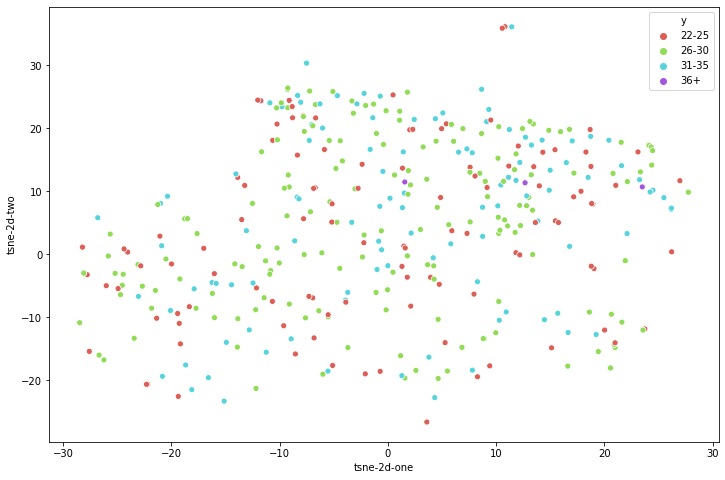

In [32]:
visuzalization(X_full_b[genders=='M'], ages[genders=='M'])

### VAE-C 

In [33]:
X_full_vae4 = np.vstack([latent_train, latent_val, latent_test])
X_full_vae4.shape

(899, 16)

In [0]:
tsne_vae4 = TSNE(random_state=42, verbose=10, n_jobs=-1, 
                 n_iter=10000, learning_rate=5, )

In [35]:
X_full_vae4 = tsne_vae4.fit_transform(X_full_vae4)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 899 samples in 0.002s...
[t-SNE] Computed neighbors for 899 samples in 0.107s...
[t-SNE] Computed conditional probabilities for sample 899 / 899
[t-SNE] Mean sigma: 1.619684
[t-SNE] Computed conditional probabilities in 0.052s
[t-SNE] Iteration 50: error = 68.0073700, gradient norm = 0.0000022 (50 iterations in 0.206s)
[t-SNE] Iteration 100: error = 67.9565430, gradient norm = 0.0035217 (50 iterations in 0.187s)
[t-SNE] Iteration 150: error = 65.8390579, gradient norm = 0.0000315 (50 iterations in 0.185s)
[t-SNE] Iteration 200: error = 65.8393707, gradient norm = 0.0000362 (50 iterations in 0.171s)
[t-SNE] Iteration 250: error = 65.8393936, gradient norm = 0.0000340 (50 iterations in 0.188s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.839394
[t-SNE] Iteration 300: error = 2.2889218, gradient norm = 0.0047773 (50 iterations in 0.164s)
[t-SNE] Iteration 350: error = 1.9971268, gradient norm = 0.0042057 (

Visualization of all data depending on ages.

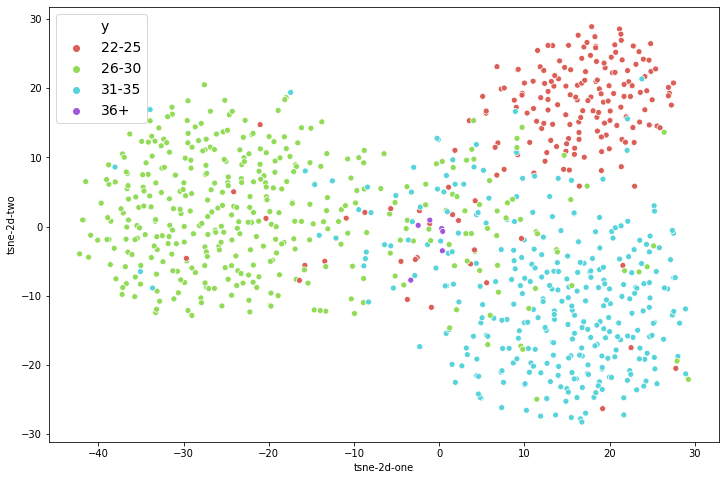

In [71]:
visuzalization(X_full_vae4, ages, output_path=os.path.join(path, 'vae4_all_ages.pdf'))

Visualization of features of objects with gender feature 'Female'.

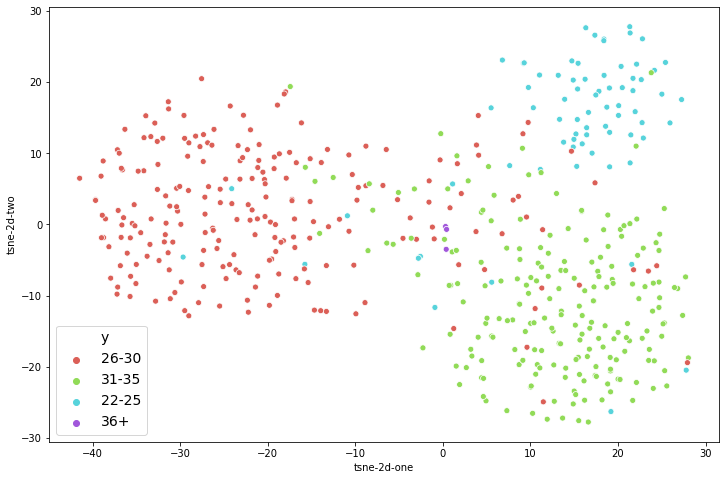

In [72]:
visuzalization(X_full_vae4[genders=='F'], ages[genders=='F'])

Visualization of features of objects with gender feature 'Male'.

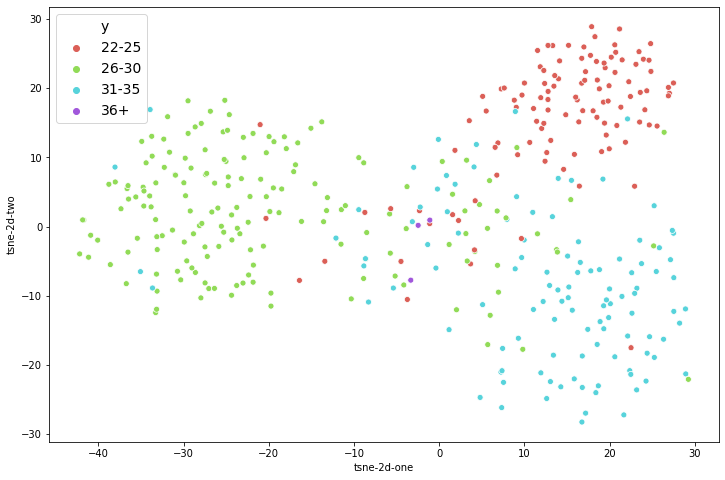

In [73]:
visuzalization(X_full_vae4[genders=='M'], ages[genders=='M'])

### VAE-C for $2$-class classification

In [60]:
X_full_vae2 = np.vstack([latent_train2, latent_val2, latent_test2])
X_full_vae2.shape

(899, 16)

In [0]:
tsne_vae2 = TSNE(random_state=42, verbose=10, n_jobs=-1, 
                 n_iter=10000, learning_rate=5, )

In [62]:
X_full_vae2 = tsne_vae2.fit_transform(X_full_vae2)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 899 samples in 0.002s...
[t-SNE] Computed neighbors for 899 samples in 0.105s...
[t-SNE] Computed conditional probabilities for sample 899 / 899
[t-SNE] Mean sigma: 1.446724
[t-SNE] Computed conditional probabilities in 0.048s
[t-SNE] Iteration 50: error = 67.4331589, gradient norm = 0.0000000 (50 iterations in 0.212s)
[t-SNE] Iteration 50: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 50 iterations with early exaggeration: 67.433159
[t-SNE] Iteration 100: error = 3.1343980, gradient norm = 0.0000065 (50 iterations in 0.184s)
[t-SNE] Iteration 150: error = 2.4951377, gradient norm = 0.0084834 (50 iterations in 0.198s)
[t-SNE] Iteration 200: error = 2.2919295, gradient norm = 0.0021118 (50 iterations in 0.211s)
[t-SNE] Iteration 250: error = 2.2286580, gradient norm = 0.0013826 (50 iterations in 0.208s)
[t-SNE] Iteration 300: error = 2.1882262, gradient norm = 0.0009356 (50 iterations in 0.219s)
[t-SNE] Iteration 

Visualization of all data depending on ages.

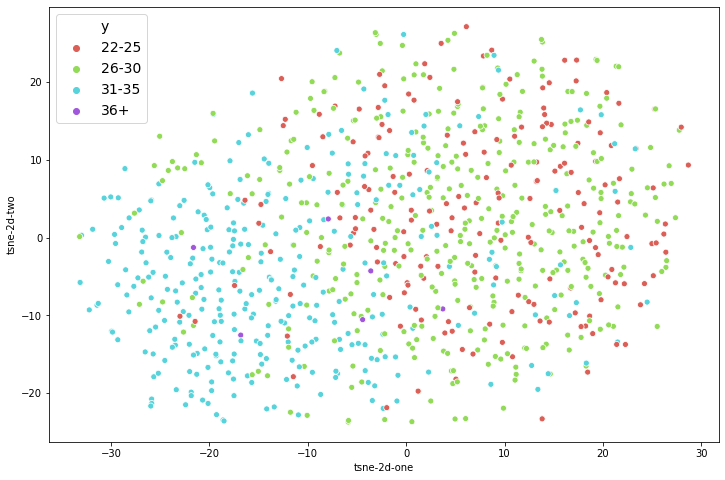

In [74]:
visuzalization(X_full_vae2, ages, output_path=os.path.join(path, 'vae2_all_ages.pdf'))

Visualization of features of objects with gender feature 'Female'.

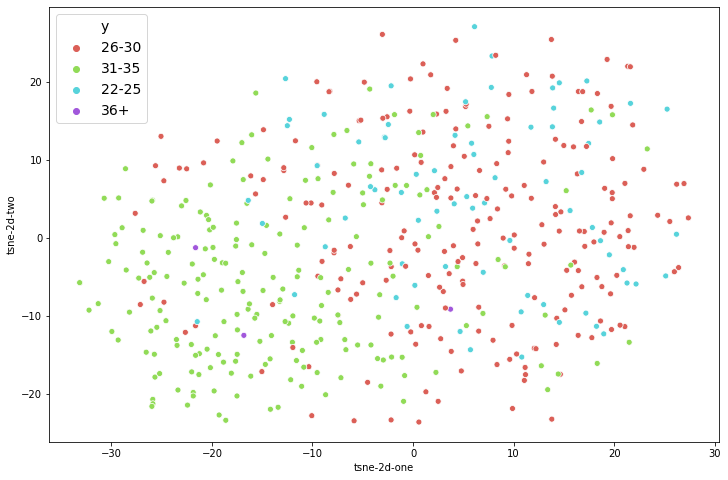

In [75]:
visuzalization(X_full_vae2[genders=='F'], ages[genders=='F'])

Visualization of features of objects with gender feature 'Male'.

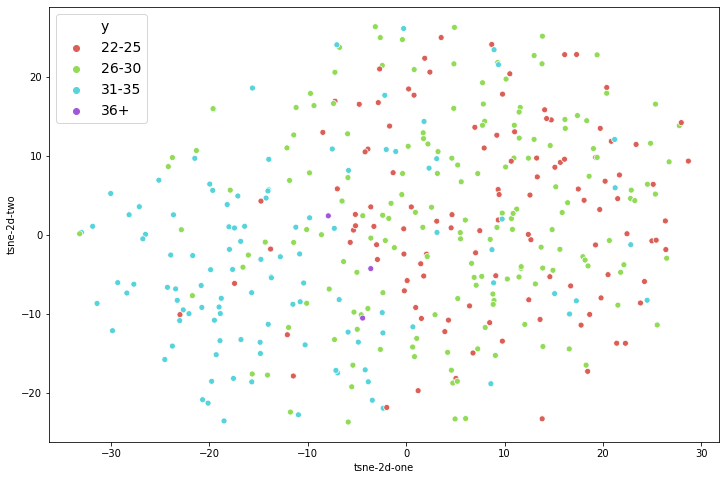

In [76]:
visuzalization(X_full_vae2[genders=='M'], ages[genders=='M'])

As in this case the classes $22-25$ and $26-30$ were joined as well as the classes $31-35$ and $36+$ then the results are acceptable: the obtained $2$ classes are well divided from each other.